# Naive Bayes

## Librairies et dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

import re

C:\Users\Eliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eliana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eliana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
dataset = load_dataset("yaful/DeepfakeTextDetect")
df = dataset["train"].to_pandas()
df.head()

,text,label,src
0,White girls very rarely date Asian men. Even i...,1,cmv_human
1,I am a 23 year old male Indian American male. ...,1,cmv_human
2,"Take three people, Persons A, B, and C. They l...",1,cmv_human
3,(A) Work part-time in high school; Then go to ...,1,cmv_human
4,When police introduce a new form of speed prev...,1,cmv_human


## Training and test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=69)

## Fonctions de créations de tokens

In [5]:
def lemma_tokenize(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(doc)]

def byte_pair_tokenize(doc):
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

## Création des modèles

In [6]:
model1 = make_pipeline(CountVectorizer(tokenizer=lemma_tokenize, stop_words = list(en_stop), ngram_range = (1,1)), MultinomialNB())
model2 = make_pipeline(CountVectorizer(tokenizer=byte_pair_tokenize, stop_words = list(en_stop), ngram_range = (1,1)), MultinomialNB())

model3 = make_pipeline(CountVectorizer(tokenizer=lemma_tokenize, stop_words = list(en_stop), ngram_range = (3,3)), MultinomialNB())
model4 = make_pipeline(CountVectorizer(tokenizer=byte_pair_tokenize, stop_words = list(en_stop), ngram_range = (3,3)), MultinomialNB())

## Entraînements, prédictions et matrices de confusion

Model: lemma


C:\Users\Eliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Eliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'doe', 'ha', 'le', 'll', 'm', 'n', 's', 't', 'u', 've', 'wa', '‘', '’'] not in stop_words.
  warnings.warn(


Features dimension: (255256, 403610)
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84     45082
           1       0.62      0.65      0.63     18733

    accuracy                           0.78     63815
   macro avg       0.73      0.74      0.74     63815
weighted avg       0.78      0.78      0.78     63815

Model: bytes-pair


C:\Users\Eliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Eliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10138', '10274', '1055', '10655', '1073', '10888', '10924', '11536', '11945', '12116', '1220', '1225', '1245', '12682', '12840', '1336', '13397', '1348', '13486', '1395', '1409', '1431', '14336', '1445', '14622', '14724', '14965', '15031', '15145', '15205', '15247', '1527', '1531', '15930', '1605', '1610', '16514', '16809', '1683', '17106', '17206', '1729', '1752', '17998', '1820', '18238', '18614', '1885', '1

Features dimension: (255256, 42543)
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79     45082
           1       0.52      0.69      0.60     18733

    accuracy                           0.73     63815
   macro avg       0.69      0.72      0.69     63815
weighted avg       0.76      0.73      0.73     63815



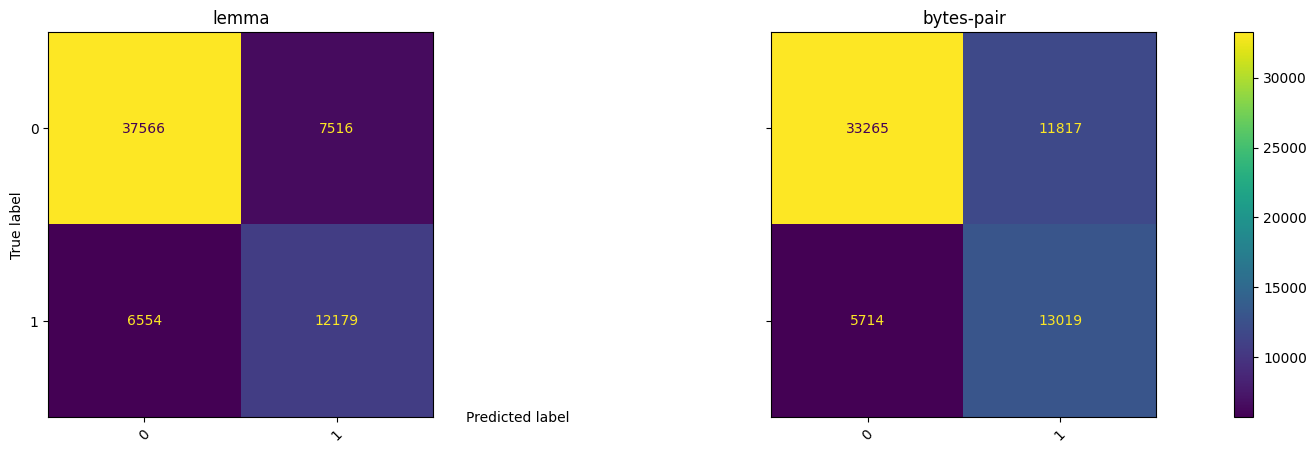

In [7]:
classifiers = {
    "lemma": model1,
    "bytes-pair": model2,
}

f, axes = plt.subplots(1, 2, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    print("Model: " + key)
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Features dimension: {len(X_train), len(classifier[0].vocabulary_)}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=classifier.classes_)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0: 
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

Model: lemma


C:\Users\Eliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Eliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'doe', 'ha', 'le', 'll', 'm', 'n', 's', 't', 'u', 've', 'wa', '‘', '’'] not in stop_words.
  warnings.warn(


Features dimension: (255256, 21209131)
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89     45082
           1       0.98      0.42      0.59     18733

    accuracy                           0.83     63815
   macro avg       0.89      0.71      0.74     63815
weighted avg       0.86      0.83      0.80     63815

Model: bytes-pair


C:\Users\Eliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Eliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10138', '10274', '1055', '10655', '1073', '10888', '10924', '11536', '11945', '12116', '1220', '1225', '1245', '12682', '12840', '1336', '13397', '1348', '13486', '1395', '1409', '1431', '14336', '1445', '14622', '14724', '14965', '15031', '15145', '15205', '15247', '1527', '1531', '15930', '1605', '1610', '16514', '16809', '1683', '17106', '17206', '1729', '1752', '17998', '1820', '18238', '18614', '1885', '1

Features dimension: (255256, 23333890)
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     45082
           1       0.98      0.48      0.64     18733

    accuracy                           0.84     63815
   macro avg       0.90      0.74      0.77     63815
weighted avg       0.87      0.84      0.82     63815



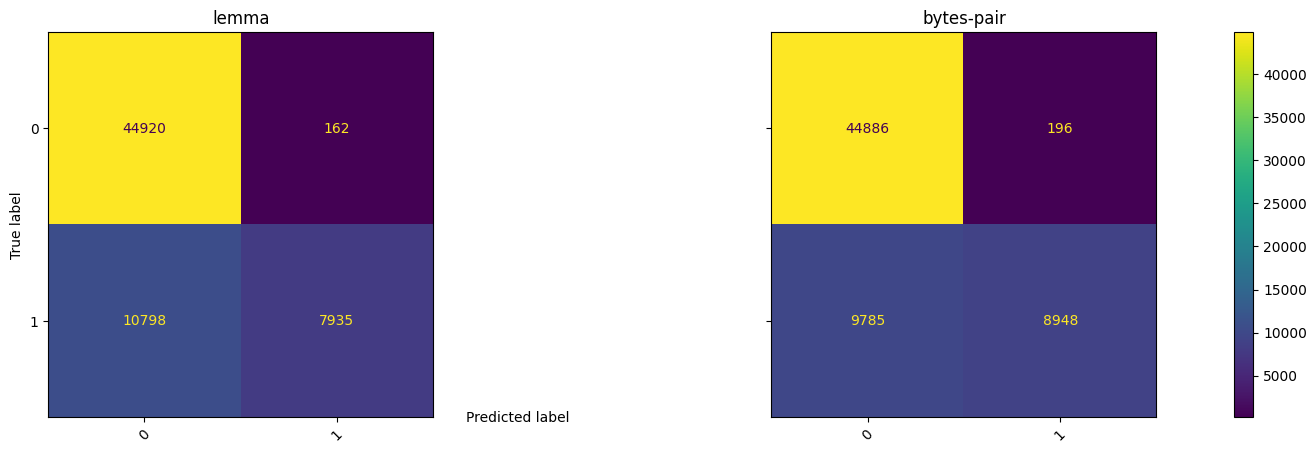

In [7]:
classifiers = {
    "lemma": model3,
    "bytes-pair": model4,
}

f, axes = plt.subplots(1, 2, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    print("Model: " + key)
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Features dimension: {len(X_train), len(classifier[0].vocabulary_)}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=classifier.classes_)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0: 
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()